# Pré-processamento Pilar de Modelagem

Agora, o objetivo é identificar um subespaço do embedding que seja capaz de capturar melhor a similaridade dos atributos de modelagem. Para isso, vamos comparar apenas produtos do mesmo grupo e criar um subespaço para cada característica, com uma estratégia equivalente ao que foi feito com o LDA no pilar de cor. 


PS: Como o modelo CLIP sem fine-tuning não foi capaz de capturar a similaridade dos produtos com relação a atributos de modelagem nas descrições textuais, vamos focar em manipulações do espaço olhando pros embeddings das imagens.

Vamos começar observando como os diferentes grupos estão distribuídos no espaço de embedding completo.

In [245]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

### Funções

In [246]:
import matplotlib.pyplot as plt

# Função para plotar os componentes reduzidos com cores definidas por um dicionário
def plot_cores(df, cor_column='COR_PRIMARIA', reducer='LDA', color_dict=None, show=True):
    """
    Plota os componentes reduzidos colorindo os pontos com base em um dicionário de cores.
    """

    # Setando componente x e y conforme o reducer
    component_x, component_y = f'EMB_{reducer}_0', f'EMB_{reducer}_1'

    # Filtrando apenas as linhas que possuem valores válidos (sem NaN) nos componentes
    df_plot = df.dropna(subset=[component_x, component_y, cor_column])

    # Se o dicionário de cores não for fornecido, gerar um dicionário de cores padrão
    if color_dict is None:
        unique_colors = df_plot[cor_column].unique()
        color_dict = {color: plt.cm.tab20(i / len(unique_colors)) for i, color in enumerate(unique_colors)}

    # Removendo linhas com cores não mapeadas no dicionário de cores
    df_plot = df_plot[df_plot[cor_column].isin(color_dict.keys())]

    # Iterar por cada cor e plotar os pontos
    for cor, color_value in color_dict.items():
        subset = df_plot[df_plot[cor_column] == cor]
        
        # Adicionar borda preta se a cor for branca
        edge_color = 'black' if color_value == '#FFFFFF' else color_value

        plt.scatter(
            subset[component_x],
            subset[component_y],
            color=color_value,
            edgecolor=edge_color,  # Define a cor da borda
            linewidth=0.5 if color_value == '#FFFFFF' else 0,  # Define a largura da borda para pontos brancos
            alpha=0.7,
            label=cor
        )

    # Botando a legenda deslocada para fora do gráfico
    plt.legend(title=f"{cor_column}", bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.xlabel(component_x)
    plt.ylabel(component_y)
    plt.title(f"Componentes {reducer} com cores de {cor_column}")
    if show:
        plt.show()


In [247]:
# Função que aplica t-SNE para reduzir para duas dimensões
from sklearn.manifold import TSNE
from umap.umap_ import UMAP

def apply_tsne(df, colunas, n_components=2, tsne=None):

    if tsne is None:
        # Removendo linhas com valores nulos para treinar o modelo

        # Inicializando o modelo t-SNE
        tsne = TSNE(n_components=n_components, random_state=42)

        # Treinando o modelo e transformando os dados
        componentes = tsne.fit_transform(df[colunas])

        # Criando um novo DataFrame com as colunas desejadas
        df_tsne = df[['id_produto']].copy() 
    else:
        # Transformando os dados
        componentes = tsne.transform(df[colunas])

        # Criando um novo DataFrame com as colunas desejadas
        df_tsne = df[['id_produto']].copy()

    for i in range(n_components):
        df_tsne[f'EMB_TSNE_{i}'] = componentes[:, i]

    return df_tsne, tsne

def apply_umap(df, colunas, n_components=2, umap=None):

    if umap is None:
        # Removendo linhas com valores nulos para treinar o modelo

        # Inicializando o modelo t-SNE
        umap = UMAP(n_components=n_components, random_state=42)

        # Treinando o modelo e transformando os dados
        componentes = umap.fit_transform(df[colunas])

        # Criando um novo DataFrame com as colunas desejadas
        df_umap = df[['id_produto']].copy() 
    else:
        # Transformando os dados
        componentes = umap.transform(df[colunas])

        # Criando um novo DataFrame com as colunas desejadas
        df_umap = df[['id_produto']].copy()

    for i in range(n_components):
        df_umap[f'EMB_UMAP_{i}'] = componentes[:, i]

    return df_umap, umap

In [248]:
from PIL import Image

def plot_image(image_path):
    image = Image.open(image_path)
    plt.imshow(image)
    plt.axis('off')
    plt.show()

In [249]:
# Puxando arquivo com embeddings de cada produto id
df_img_embs = pd.read_parquet('datasets/img_embeddings.parquet')

In [250]:
df_img_embs.sample(3)

id_produto  emb_img_0  emb_img_1  emb_img_2  emb_img_3  emb_img_4  \
729  07-20-6536-09246   0.095772  -0.205444   0.039193   0.578801  -0.305500   
365   52-15-1406-0005   0.073053  -0.016600  -0.081707   0.280411  -0.015248   
556   07-20-6490-0005   0.018320  -0.016143   0.068109   0.712223  -0.118237   

     emb_img_5  emb_img_6  emb_img_7  emb_img_8  ...  emb_img_502  \
729   0.184189  -0.563855  -0.700451   0.336983  ...     0.131682   
365  -0.020663  -0.394546  -0.837613   0.912638  ...    -0.174765   
556   0.195943  -0.280582  -0.431536   1.395533  ...    -0.106388   

     emb_img_503  emb_img_504  emb_img_505  emb_img_506  emb_img_507  \
729    -0.324027     0.037582     0.165372     0.005305     0.035322   
365    -0.091361     0.102554    -0.008705     0.141389     0.026073   
556    -0.296961     0.770874    -0.103412    -0.045825    -0.350381   

     emb_img_508  emb_img_509  emb_img_510  emb_img_511  
729    -0.052480     0.822832    -0.329194     0.393875  
365    -0.167427     1.430294    -0.277512     0.331612  
556     0.109525     0.808756    -0.392015    -0.031624  

[3 rows x 513 columns]

In [251]:
# Reduzindo com umap
df_img_embs_umap, umap = apply_umap(df_img_embs, colunas=df_img_embs.columns[1:], n_components=2)

c:\Users\Cole\AppData\Local\Programs\Python\Python311\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


In [252]:
# Puxando arquivo com categorização de cada produto id
df_categories = pd.read_parquet('datasets/base.parquet')

In [253]:
# Puxando coluna grupo_produto de df_categories
df_img_embs_umap = pd.merge(df_img_embs_umap, df_categories[['id_produto', 'grupo_produto']], on='id_produto')

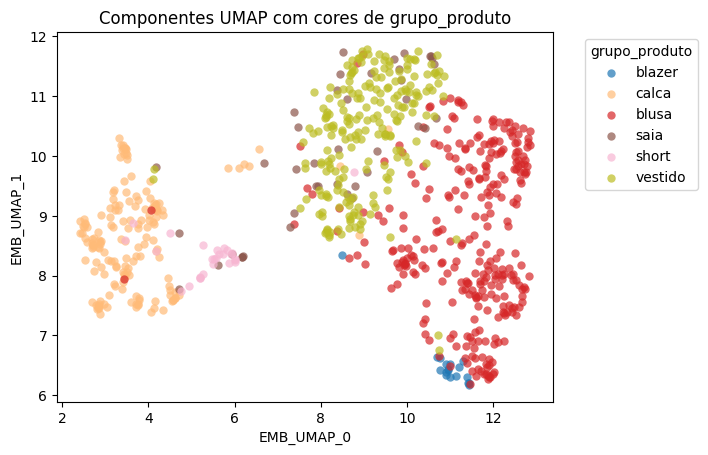

In [254]:
plot_cores(df_img_embs_umap, cor_column='grupo_produto', reducer='UMAP', show=True)

In [255]:
df_categories.sample(3)

file_path        id_produto  \
110  animale_images_cropped/calca/calca_calca-de-sa...  25-34-2067-01020   
126  animale_images_cropped/calca/calca_calca-de-tw...  25-34-1201-09251   
494  animale_images_cropped/saia/saia_saia-de-couro...   25-11-1254-8259   

    grupo_produto                                          file_name  \
110         calca  calca_calca-de-sarja-caramelo-com-pence-perna_...   
126         calca  calca_calca-de-twill-sarjado-nude-marzipan-bol...   
494          saia  saia_saia-de-couro-midi-classica-fenda_vermelh...   

                                                  link          PRODUTOS  \
110  https://animaleproductsimages.s3.us-east-1.ama...  25-34-2067-01020   
126  https://animaleproductsimages.s3.us-east-1.ama...  25-34-1201-09251   
494  https://animaleproductsimages.s3.us-east-1.ama...   25-11-1254-8259   

                                       CARACTERISTICAS LOCALIZACAO_ESTAMPA  \
110  {COMPRIMENTO: MEIO_CANELA;TIPO_CINTURA: MEDIA;...                 N/A   
126  {COMPRIMENTO: MEIO_COXA;TIPO_CINTURA: MEDIA;MO...                 N/A   
494  {COMPRIMENTO: MEIO_CANELA;MODELAGEM: REGULAR;T...                 N/A   

    COR_PREDOMINANTE DECOTE_OU_GOLA  ...  ESTILO TIPO_MANGA TIPO_CINTURA  \
110             BEGE           None  ...  CASUAL       None        MEDIA   
126             BEGE           None  ...  CASUAL       None        MEDIA   
494         VERMELHO           None  ...  CASUAL       None        MEDIA   

     COMPRIMENTO  MODELAGEM      ESTAMPA FENDA_PERNA MODELAGEM_SAIA  \
110  MEIO_CANELA  PANTALONA  SEM_ESTAMPA         N/A           None   
126    MEIO_COXA  PANTALONA  SEM_ESTAMPA         N/A           None   
494  MEIO_CANELA    REGULAR  SEM_ESTAMPA         SIM           None   

    TIPO_BARRA                                       desc_produto  
110       RETA            calca de sarja caramelo com pence perna  
126    DOBRADA  calca de twill sarjado nude marzipan bolso qua...  
494       RETA                  saia de couro midi classica fenda  

[3 rows x 24 columns]

In [256]:
df_categories['grupo_produto'].value_counts()

blusa      299
vestido    216
calca      165
saia        41
short       27
blazer      18
Name: grupo_produto, dtype: int64

In [257]:
df_vestido = df_categories.loc[df_categories['grupo_produto'] == 'vestido']
df_blusa = df_categories.loc[df_categories['grupo_produto'] == 'blusa']
df_calca = df_categories.loc[df_categories['grupo_produto'] == 'calca']
df_saia = df_categories.loc[df_categories['grupo_produto'] == 'saia']
df_short = df_categories.loc[df_categories['grupo_produto'] == 'short']
df_blazer = df_categories.loc[df_categories['grupo_produto'] == 'blazer']

In [258]:
# Exibindo colunas que tem pelo menos um valor não nulo
df_vestido.count()

file_path              216
id_produto             216
grupo_produto          216
file_name              216
link                   216
PRODUTOS               216
CARACTERISTICAS        216
LOCALIZACAO_ESTAMPA    216
COR_PREDOMINANTE       216
DECOTE_OU_GOLA         216
COMPRIMENTO_SAIA       216
AMARRACAO              216
ZOOM_ESTAMPA           216
COMPRIMENTO_MANGA      216
ESTILO                 216
TIPO_MANGA             216
TIPO_CINTURA             0
COMPRIMENTO              0
MODELAGEM                0
ESTAMPA                216
FENDA_PERNA            216
MODELAGEM_SAIA         216
TIPO_BARRA               0
desc_produto           216
dtype: int64

In [259]:
atributos_mod_vestido = ['COMPRIMENTO_SAIA', 'COMPRIMENTO_MANGA', 'TIPO_MANGA', 'MODELAGEM_SAIA', 'DECOTE_OU_GOLA', 'FENDA_PERNA', 'AMARRACAO']

In [260]:
for atributo in atributos_mod_vestido:
    print(df_vestido[atributo].value_counts())

CALCANHAR         80
MEIO_COXA         74
MINI              43
JOELHO             7
MEIO_CALCANHAR     6
MEIO_CANELA        4
N/A                1
MEIO_MENGANNA      1
Name: COMPRIMENTO_SAIA, dtype: int64
SEM_MANGA       141
COMPRIDA         28
CURTA            15
LONGA            15
ALÇA             13
N/A               2
TRES_QUARTOS      1
TRÊS_QUARTOS      1
Name: COMPRIMENTO_MANGA, dtype: int64
N/A              150
REGULAR           30
OMBRO_UNICO       12
BUFANTE           11
FLARE              6
OMBRO_A_OMBRO      4
KIMONO             2
AMPLA              1
Name: TIPO_MANGA, dtype: int64
REGULAR         122
EVASÊ            59
ASSIMETRICA      10
TRANSPASSADA      9
N/A               8
COM_BABADOS       3
PLISSADA          2
LAPIS             1
GODÊ              1
SEREIA            1
Name: MODELAGEM_SAIA, dtype: int64
V                  78
TOMARA_QUE_CAIA    32
REDONDA            29
RETO               19
HALTER             16
OMBRO_A_OMBRO      11
CORACAO             9
QUADRADA 

Hipotéses:
- todos os curtos foram classificados em mini
- todos os meio_coxa são meio_canela


In [261]:
# Pegando exemplos de df_vestidos que são comprimento meio_coxa
files_paths = df_vestido.loc[df_vestido['COMPRIMENTO_SAIA'] == 'MEIO_COXA']['file_path'].values

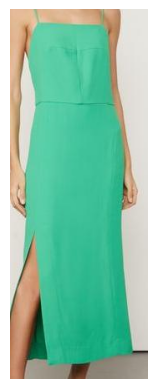

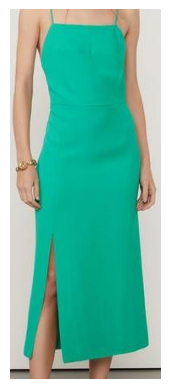

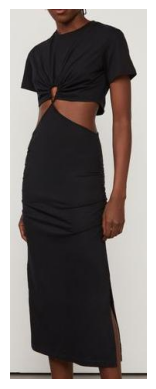

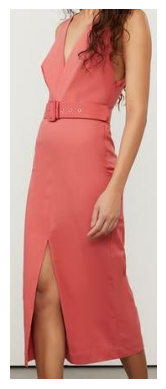

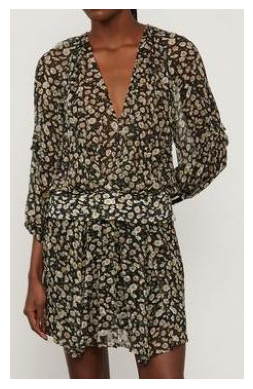

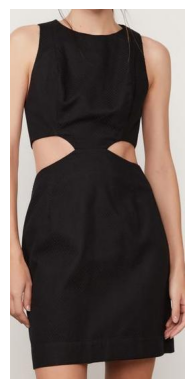

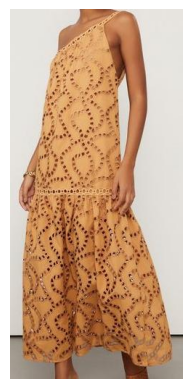

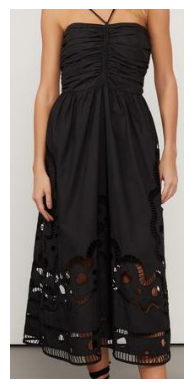

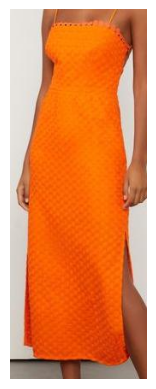

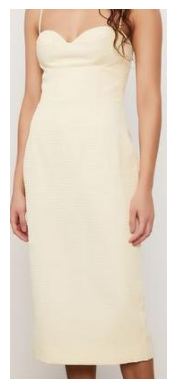

In [262]:
# Plotando alguns exemplos de files_paths
for i in range(10):
    plot_image(files_paths[i])
    # input_code= input("1-Meio coxa, 2-Longo, 3-Curto: ")

In [263]:
# Pegando exemplos de df_vestidos que são comprimento meio_coxa
files_paths = df_vestido.loc[df_vestido['DECOTE_OU_GOLA'] == 'OMBRO_A_OMBRO']['file_path'].values

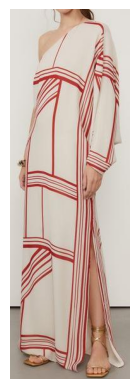

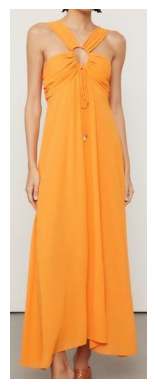

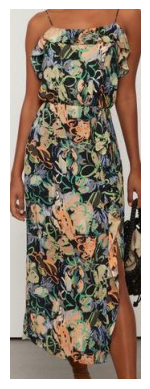

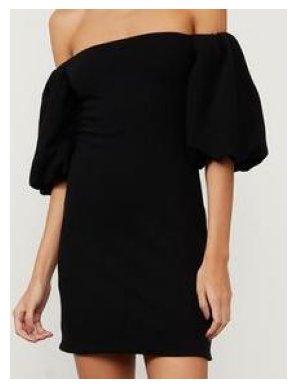

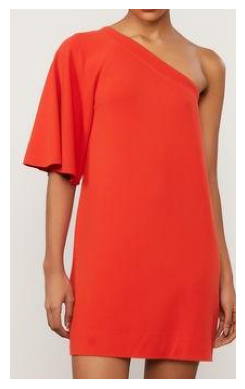

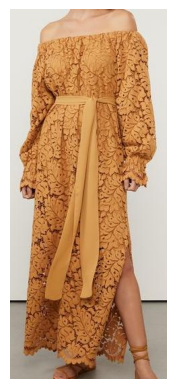

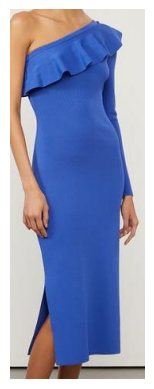

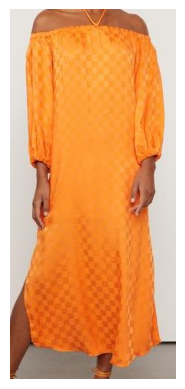

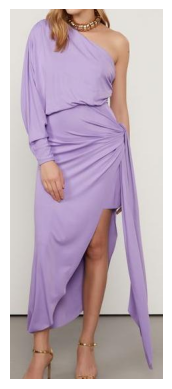

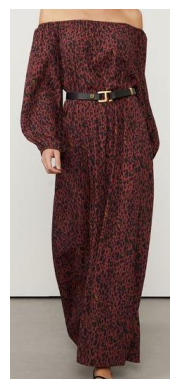

In [264]:
for i in range(10):
    plot_image(files_paths[i])
    # input_code= input("1-Ombro só, 2-Decote V, 3-Decote redondo: ")

#### Checkpoint: o tagueamento dos atributos de modelagem com o gpt-4o-mini tem muitos erros e precisará ser refeito.

Pontos a considerar:
- as categorias de modelagem precisam ser mais simples e objetivas, para evitar ambiguidades e inconsistências
- precisamos de menos categorias para que os clusters sejam mais claros e não haja poucos exemplos em cada categoria
- o gpt classifica melhor as imagens inteiras do que segmentadas

Próximos passos:

- revisar os atributos pra cada grupo
- rodar no gpt de novo (outro modelo) com as imagens resizadas
- reavaliar os atributos
- seguir com a modelagem

### Revisão dos atributos

#### VESTIDO

- se as mangas forem assimétricas considere o comprimento_manga da manga mais comprida (se um lado for manga curta e outro lado manga longa, considere longa, mas se um lado for sem_manga e o outro manga curta, considere manga curta)
- não considere amarrações no pescoço na hora de categorizar AMARRACAO_CORPO

COMPRIMENTO_SAIA: CURTO, MIDI, LONGO

MODELAGEM_SAIA: JUSTA, RETA, SOLTA

COMPRIMENTO_MANGA: SEM_MANGA, ALÇA, MANGA_CURTA, MANGA_MEDIA, MANGA_LONGA

DECOTE_OU_GOLA: DECOTE_V, DECOTE_RENDONDO, DECOTE_RETO, DECOTE_CORACAO, AMARRACAO_PESCOCO, DECOTE_TOMARA_QUE_CAIA, DECOTE_UM_OMBRO_SO, DECOTE_OMBRO_A_OMBRO, GOLA_POLO, GOLA_ALTA

FENDA_PERNA: N/A, SIM

AMARRACAO_CORPO: N/A, SIM

#### BLUSA

- Considere comprimento top apenas as blusas que tiverem a modelagem de top (mais justas e curtas que as que devem ser categorizadas como CURTA)

COMPRIMENTO_BLUSA: TOP, CURTA, LONGA

COMPRIMENTO_MANGA: SEM_MANGA, ALÇA, MANGA_CURTA, MANGA_MEDIA, MANGA_LONGA

DECOTE_OU_GOLA: DECOTE_V, DECOTE_RENDONDO, DECOTE_RETO, DECOTE_CORACAO, AMARRACAO_PESCOCO, DECOTE_TOMARA_QUE_CAIA, DECOTE_UM_OMBRO_SO, DECOTE_OMBRO_A_OMBRO, GOLA_POLO, GOLA_ALTA

FENDA_PERNA: N/A, SIM

AMARRACAO_CORPO: N/A, SIM

#### SAIA

Muuuito melhor com 10 dimensões! Conseguimos ver uma separação mais clara das cores.

COMPRIMENTO_SAIA: CURTO, MIDI, LONGO

MODELAGEM_SAIA: JUSTA, RETA, SOLTA

FENDA_PERNA: N/A, SIM

AMARRACAO_CORPO: N/A, SIM

#### CALÇA

COMPRIMENTO_CALCA = CALCANHAR, CANELA

MODELAGEM_CALCA = PANTALONA, RETA, JUSTA, SOLTA, FLARE

ALTURA_COS = CINTURA_ALTA, CINTURA_BAIXA

AMARRACAO_CORPO: N/A, SIM

FENDA_PERNA: N/A, SIM

#### SHORT

COMPRIMENTO_SHORT = CURTO, LONGO

MODELAGE_SHORT = JUSTO, RETO, SOLTO

ALTURA_COS = CINTURA_ALTA, CINTURA_BAIXA

AMARRACAO_CORPO = N/A, SIM

#### BLAZER

COMPRIMENTO_BLAZER: LONGO, MEDIO, CURTO

MODELAGEM_BLAZER: RETA, AJUSTADA, OVERSIZED

COMPRIMENTO_MANGA: CURTA, TRES_QUARTOS, COMPRIDA

Observações pra inserir no PROMPT:

- se as mangas da roupa forem assimétricas considere o comprimento_manga da manga mais comprida (se um lado for manga curta e outro lado manga longa, considere longa, mas se um lado for sem_manga e o outro manga curta, considere manga curta)
- Considere COMPRIMENTO_BLUSA = TOP apenas para as blusas que tiverem a modelagem de top (mais justas e curtas que as que devem ser categorizadas como COMPRIMENTO_BLUSA = CURTA)
- Não considere amarrações no pescoço na hora de categorizar AMARRACAO_CORPO, nem a presença de cintos
- Tenha cautela na hora de categorizar o comprimento das blusas, pois elas podem estar por dentro da peça de baixo e confundir

### Nova categorização com gpt-4o

In [265]:
# Puxando arquivo com categorização de cada produto id
df_categories_4o = pd.read_parquet('datasets/base_animale_categorizada_4o.parquet')

In [266]:
df_categories_4o.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 766 entries, 0 to 765
Data columns (total 28 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   file_path            766 non-null    object
 1   id_produto           766 non-null    object
 2   grupo_produto        766 non-null    object
 3   file_name            766 non-null    object
 4   original_file_path   766 non-null    object
 5   link                 766 non-null    object
 6   PRODUTOS             765 non-null    object
 7   CARACTERISTICAS      765 non-null    object
 8   ESTAMPA              764 non-null    object
 9   AMARRACAO_PESCOCO    215 non-null    object
 10  COMPRIMENTO_BLAZER   18 non-null     object
 11  COR_PREDOMINANTE     764 non-null    object
 12  COMPRIMENTO_SHORT    27 non-null     object
 13  MODELAGEM_SHORT      27 non-null     object
 14  DECOTE_OU_GOLA       514 non-null    object
 15  AMARRACAO_CORPO      746 non-null    object
 16  ALTURA_C

In [267]:
df_vestido = df_categories_4o.loc[df_categories_4o['grupo_produto'] == 'vestido'].copy()
df_blusa = df_categories_4o.loc[df_categories_4o['grupo_produto'] == 'blusa'].copy()
df_calca = df_categories_4o.loc[df_categories_4o['grupo_produto'] == 'calca'].copy()
df_saia = df_categories_4o.loc[df_categories_4o['grupo_produto'] == 'saia'].copy()
df_short = df_categories_4o.loc[df_categories_4o['grupo_produto'] == 'short'].copy()
df_blazer = df_categories_4o.loc[df_categories_4o['grupo_produto'] == 'blazer'].copy()

##### VESTIDO

In [268]:
atributos_mod_vestido = ['COMPRIMENTO_SAIA', 'COMPRIMENTO_MANGA', 'MODELAGEM_SAIA', 'DECOTE_OU_GOLA', 'FENDA_PERNA', 'AMARRACAO_CORPO', 'AMARRACAO_PESCOCO']

In [269]:
for atributo in atributos_mod_vestido:
    print(df_vestido[atributo].value_counts())

MIDI     94
LONGA    76
CURTA    45
Name: COMPRIMENTO_SAIA, dtype: int64
ALCA               105
SEM_MANGA           40
MANGA_LONGA         35
MANGA_MEDIA         19
MANGA_CURTA          7
UM_OMBRO_SO          7
TOMARA_QUE_CAIA      2
Name: COMPRIMENTO_MANGA, dtype: int64
SOLTA     129
JUSTA      63
RETA       22
SEREIA      1
Name: MODELAGEM_SAIA, dtype: int64
V                  74
FRENTE_UNICA       30
RETO               29
REDONDO            22
UM_OMBRO_SO        15
CORACAO            14
TOMARA_QUE_CAIA    14
OMBRO_A_OMBRO       9
GOLA_ALTA           3
N/A                 2
DEGAGE              2
GOLA_POLO           1
Name: DECOTE_OU_GOLA, dtype: int64
N/A    142
SIM     73
Name: FENDA_PERNA, dtype: int64
N/A    135
SIM     80
Name: AMARRACAO_CORPO, dtype: int64
N/A    200
SIM     15
Name: AMARRACAO_PESCOCO, dtype: int64


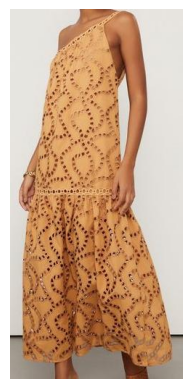

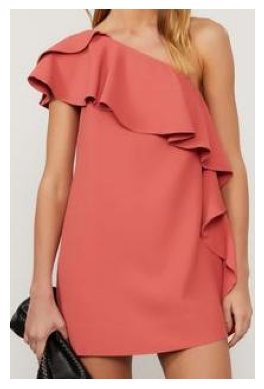

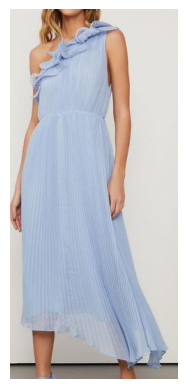

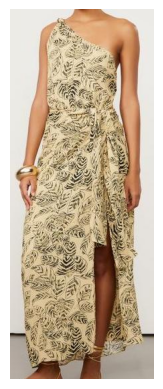

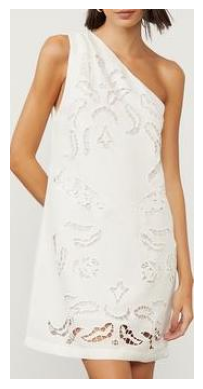

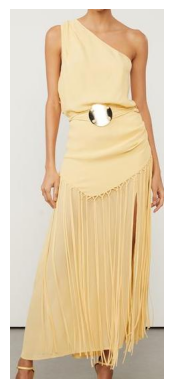

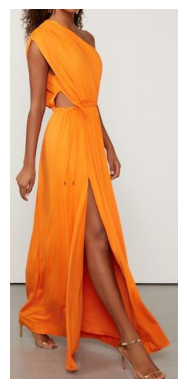

In [270]:
# Exibindo imagens em que COMPRIMENTO_MANGA = UM_OMBRO_SO
files_paths = df_vestido.loc[df_vestido['COMPRIMENTO_MANGA'] == 'UM_OMBRO_SO']['file_path'].values

for i in range(len(files_paths)):
    plot_image(files_paths[i])


Quando COMPRIMENTO_MANGA = UM_OMBRO_SO substituir DECOTE_OU_GOLA = UM_OMBRO_SO e COMPRIMENTO_MANGA = SEM_MANGA

In [271]:
df_vestido.loc[df_vestido['COMPRIMENTO_MANGA'] == 'UM_OMBRO_SO', 'DECOTE_OU_GOLA'] = 'UM_OMBRO_SO'
df_vestido.loc[df_vestido['COMPRIMENTO_MANGA'] == 'UM_OMBRO_SO', 'COMPRIMENTO_MANGA'] = 'SEM_MANGA'

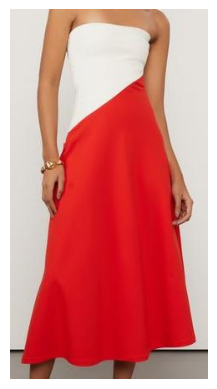

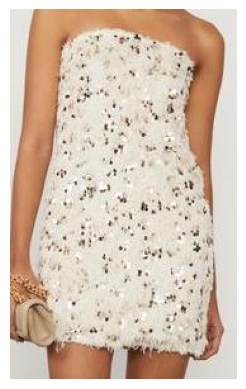

In [272]:
# Exibindo imagens em que COMPRIMENTO_MANGA = TOMARA_QUE_CAIA
files_paths = df_vestido.loc[df_vestido['COMPRIMENTO_MANGA'] == 'TOMARA_QUE_CAIA']['file_path'].values

for i in range(len(files_paths)):
    plot_image(files_paths[i])

Quando COMPRIMENTO_MANGA = TOMARA_QUE_CAIA substituir DECOTE_OU_GOLA = TOMARA_QUE_CAIA e COMPRIMENTO_MANGA = SEM_MANGA

In [273]:
df_vestido.loc[df_vestido['COMPRIMENTO_MANGA'] == 'TOMARA_QUE_CAIA', 'DECOTE_OU_GOLA'] = 'TOMARA_QUE_CAIA'
df_vestido.loc[df_vestido['COMPRIMENTO_MANGA'] == 'TOMARA_QUE_CAIA', 'COMPRIMENTO_MANGA'] = 'SEM_MANGA'

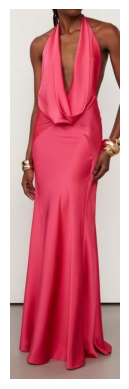

In [274]:
# Exibindo imagens em que MODELAGEM_SAIA = SEREIA
files_paths = df_vestido.loc[df_vestido['MODELAGEM_SAIA'] == 'SEREIA']['file_path'].values

for i in range(len(files_paths)):
    plot_image(files_paths[i])

In [275]:
# Substituindo MODELAGEM_SAIA = SEREIA por MODELAGEM_SAIA = SOLTA
df_vestido.loc[df_vestido['MODELAGEM_SAIA'] == 'SEREIA', 'MODELAGEM_SAIA'] = 'SOLTA'

DECOTE_OU_GOLA = FRENTE_UNICA está problemático

#### BLUSA

In [276]:
atributos_mod_blusa = ['COMPRIMENTO_BLUSA', 'COMPRIMENTO_MANGA', 'DECOTE_OU_GOLA', 'AMARRACAO_CORPO']

In [277]:
for atributo in atributos_mod_blusa:
    print(df_blusa[atributo].value_counts())

CURTA    198
LONGA     63
TOP       38
Name: COMPRIMENTO_BLUSA, dtype: int64
MANGA_LONGA     94
ALCA            79
MANGA_MEDIA     43
MANGA_CURTA     38
SEM_MANGA       37
UM_OMBRO_SO      6
FRENTE_UNICA     1
N/A              1
Name: COMPRIMENTO_MANGA, dtype: int64
REDONDO            87
V                  82
RETO               35
GOLA_ALTA          27
GOLA_POLO          21
UM_OMBRO_SO        15
FRENTE_UNICA       13
TOMARA_QUE_CAIA     7
CORACAO             6
OMBRO_A_OMBRO       3
N/A                 2
DEGAGE              1
Name: DECOTE_OU_GOLA, dtype: int64
N/A    257
SIM     41
NA       1
Name: AMARRACAO_CORPO, dtype: int64


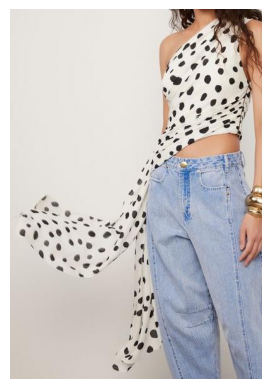

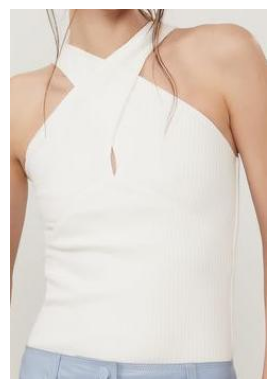

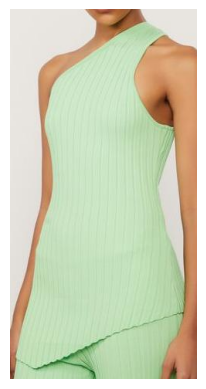

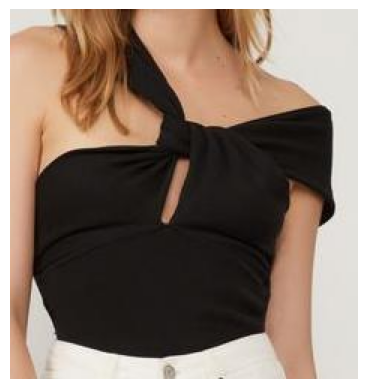

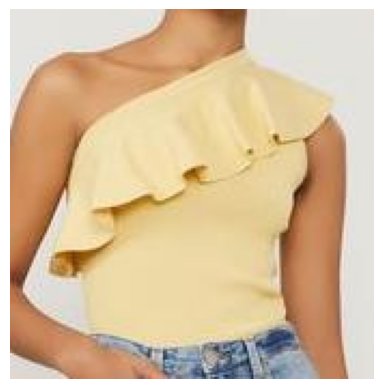

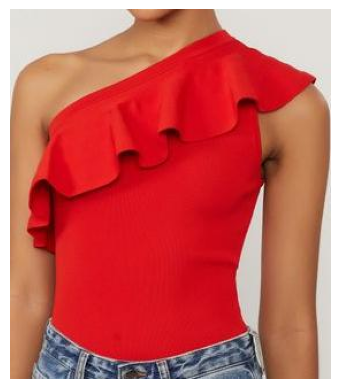

In [278]:
# Exibindo imagens em que COMPRIMENTO_MANGA = UM_OMBRO_SO
files_paths = df_blusa.loc[df_blusa['COMPRIMENTO_MANGA'] == 'UM_OMBRO_SO']['file_path'].values

for i in range(len(files_paths)):
    plot_image(files_paths[i])


In [279]:
df_blusa.loc[df_blusa['COMPRIMENTO_MANGA'] == 'UM_OMBRO_SO', 'DECOTE_OU_GOLA'] = 'UM_OMBRO_SO'
df_blusa.loc[df_blusa['COMPRIMENTO_MANGA'] == 'UM_OMBRO_SO', 'COMPRIMENTO_MANGA'] = 'SEM_MANGA'

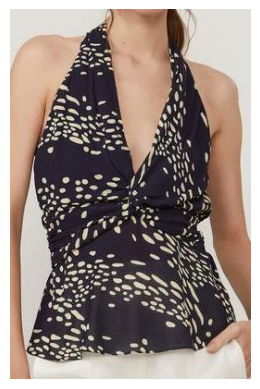

In [280]:
# COMPRIMENTO_MANGA FRENTE_UNICA
files_paths = df_blusa.loc[df_blusa['COMPRIMENTO_MANGA'] == 'FRENTE_UNICA']['file_path'].values

for i in range(len(files_paths)):
    plot_image(files_paths[i])

In [281]:
# Substituindo COMPRIMENTO_MANGA = FRENTE_UNICA por COMPRIMENTO_MANGA = SEM_MANGA
df_blusa.loc[df_blusa['COMPRIMENTO_MANGA'] == 'FRENTE_UNICA', 'COMPRIMENTO_MANGA'] = 'SEM_MANGA'
df_blusa.loc[df_blusa['COMPRIMENTO_MANGA'] == 'FRENTE_UNICA', 'DECOTE_OU_GOLA'] = 'FRENTE_UNICA'

In [282]:
# Substituir NA por N/A
df_blusa.loc[df_blusa['DECOTE_OU_GOLA'].isna(), 'DECOTE_OU_GOLA'] = 'N/A'

In [283]:
for atributo in atributos_mod_blusa:
    print(df_blusa[atributo].value_counts())

CURTA    198
LONGA     63
TOP       38
Name: COMPRIMENTO_BLUSA, dtype: int64
MANGA_LONGA    94
ALCA           79
SEM_MANGA      44
MANGA_MEDIA    43
MANGA_CURTA    38
N/A             1
Name: COMPRIMENTO_MANGA, dtype: int64
REDONDO            87
V                  82
RETO               35
GOLA_ALTA          27
GOLA_POLO          21
UM_OMBRO_SO        15
FRENTE_UNICA       13
TOMARA_QUE_CAIA     7
CORACAO             6
OMBRO_A_OMBRO       3
N/A                 2
DEGAGE              1
Name: DECOTE_OU_GOLA, dtype: int64
N/A    257
SIM     41
NA       1
Name: AMARRACAO_CORPO, dtype: int64


#### SAIA

In [284]:
atributos_mod_saia = ['COMPRIMENTO_SAIA', 'MODELAGEM_SAIA', 'FENDA_PERNA', 'AMARRACAO_CORPO']

In [285]:
for atributo in atributos_mod_saia:
    print(df_saia[atributo].value_counts())

MIDI     15
LONGA    15
CURTA    11
Name: COMPRIMENTO_SAIA, dtype: int64
RETA     16
SOLTA    16
JUSTA     9
Name: MODELAGEM_SAIA, dtype: int64
N/A    28
SIM    13
Name: FENDA_PERNA, dtype: int64
N/A    31
SIM    10
Name: AMARRACAO_CORPO, dtype: int64


#### CALÇA

In [286]:
atributos_mod_calca = ['COMPRIMENTO_CALCA', 'MODELAGEM_CALCA', 'ALTURA_COS', 'AMARRACAO_CORPO', 'FENDA_PERNA']

In [287]:
for atributo in atributos_mod_calca:
    print(df_calca[atributo].value_counts())

CANELA       86
CALCANHAR    78
Name: COMPRIMENTO_CALCA, dtype: int64
SOLTA        75
RETA         48
PANTALONA    20
JUSTA        14
FLARE         7
Name: MODELAGEM_CALCA, dtype: int64
CINTURA_ALTA     163
CINTURA_MEDIA      1
Name: ALTURA_COS, dtype: int64
N/A    149
SIM     15
Name: AMARRACAO_CORPO, dtype: int64
N/A    149
SIM     15
Name: FENDA_PERNA, dtype: int64


#### SHORT

In [288]:
atributos_mod_short = ['COMPRIMENTO_SHORT', 'MODELAGEM_SHORT', 'ALTURA_COS', 'AMARRACAO_CORPO']

In [289]:
for atributo in atributos_mod_short:
    print(df_short[atributo].value_counts())

CURTO    19
LONGO     8
Name: COMPRIMENTO_SHORT, dtype: int64
RETO     18
SOLTO     9
Name: MODELAGEM_SHORT, dtype: int64
CINTURA_ALTA    27
Name: ALTURA_COS, dtype: int64
N/A    24
SIM     3
Name: AMARRACAO_CORPO, dtype: int64


#### BLAZER

In [290]:
atributos_mod_blazer = ['COMPRIMENTO_BLAZER', 'MODELAGEM_BLAZER', 'COMPRIMENTO_MANGA']

In [291]:
for atributo in atributos_mod_blazer:
    print(df_blazer[atributo].value_counts())

MEDIO    10
LONGO     6
CURTO     2
Name: COMPRIMENTO_BLAZER, dtype: int64
RETA        12
AJUSTADA     6
Name: MODELAGEM_BLAZER, dtype: int64
COMPRIDA    17
N/A          1
Name: COMPRIMENTO_MANGA, dtype: int64


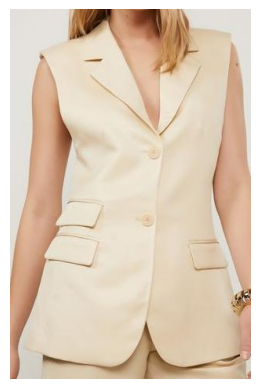

In [292]:
# Verificando caso em que COMPRIMENTO_MANGA = N/A
files_paths = df_blazer.loc[df_blazer['COMPRIMENTO_MANGA'] == 'N/A']['file_path'].values

for i in range(len(files_paths)):
    plot_image(files_paths[i])

In [293]:
# Substituindo COMPRIMENTO_MANGA = N/A por COMPRIMENTO_MANGA = SEM_MANGA
df_blazer.loc[df_blazer['COMPRIMENTO_MANGA'] == 'N/A', 'COMPRIMENTO_MANGA'] = 'SEM_MANGA'

In [294]:
ATRIBUTOS_MOD = atributos_mod_vestido + atributos_mod_blusa + atributos_mod_calca + atributos_mod_saia + atributos_mod_short + atributos_mod_blazer

# Drop duplicates de ATRIBUTOS_MOD
ATRIBUTOS_MOD = list(set(ATRIBUTOS_MOD))

In [295]:
# pegando tudo que nao esta na interseção entre ATRIBUTOS_MOD e atributos_mod_vestido

# Converter as listas em sets
set1 = set(atributos_mod_vestido)
set2 = set(ATRIBUTOS_MOD)

# Obter os elementos que estão em apenas uma das listas
outer_join = list(set1.symmetric_difference(set2))
outer_join


['ALTURA_COS',
 'MODELAGEM_SHORT',
 'COMPRIMENTO_BLAZER',
 'MODELAGEM_BLAZER',
 'COMPRIMENTO_SHORT',
 'COMPRIMENTO_BLUSA',
 'COMPRIMENTO_CALCA',
 'MODELAGEM_CALCA']

In [296]:
# dicionário com os atributos de cada grupo de produto
atributos_grupo_produto = {
    'vestido': atributos_mod_vestido,
    'blusa': atributos_mod_blusa,
    'calca': atributos_mod_calca,
    'saia': atributos_mod_saia,
    'short': atributos_mod_short,
    'blazer': atributos_mod_blazer
}

In [297]:
# Mantendo em cada df_{grupo_produto} apenas as colunas referentes a sua categoria (interseção entre ATRIBUTOS_MOD e atributos_mod_{grupo_produto})
for grupo in df_categories_4o['grupo_produto'].unique():
    # Converter as listas em sets
    set1 = set(atributos_grupo_produto[grupo])
    set2 = set(ATRIBUTOS_MOD)

    # Obter os elementos que estão em apenas uma das listas
    outer_join = list(set1.symmetric_difference(set2))

    df = globals()[f'df_{grupo}']
    df.drop(columns=outer_join, inplace=True)

In [302]:
df_vestido.columns

Index(['file_path', 'id_produto', 'grupo_produto', 'file_name',
       'original_file_path', 'link', 'PRODUTOS', 'CARACTERISTICAS', 'ESTAMPA',
       'AMARRACAO_PESCOCO', 'COR_PREDOMINANTE', 'DECOTE_OU_GOLA',
       'AMARRACAO_CORPO', 'ESTILO', 'ZOOM_ESTAMPA', 'COMPRIMENTO_MANGA',
       'FENDA_PERNA', 'LOCALIZACAO_ESTAMPA', 'MODELAGEM_SAIA',
       'COMPRIMENTO_SAIA'],
      dtype='object')

In [304]:
# Salvando df_{grupo_produto} com as colunas corretas em datasets/PILAR_MOD {grupo_produto}.parquet
for grupo in df_categories_4o['grupo_produto'].unique():
    globals()[f'df_{grupo}'].to_parquet(f'datasets/PILAR_MOD/df_{grupo}.parquet')